In [1]:
import numpy as np
import pandas as pd
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold




In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

PassengerId = test['PassengerId']

full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset["FamilySize"] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare']= pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset["Title"] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', "Capt", 'Col',
                                                 'Don', "Dr", 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mne', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({"female": 0, "male": 1}).astype(int)
    title_mapping = {"Mr": 1, "Miss":2, "Mrs": 3, "Master":4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map({"S": 0, "C":1, "Q":2}).astype(int)

    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.45), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.45) & (dataset['Fare'] <= 31 ), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31, 'Fare')] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age'] >16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) , 'Age'] = 4


ValueError: Cannot cast interval[float64] dtype to float64

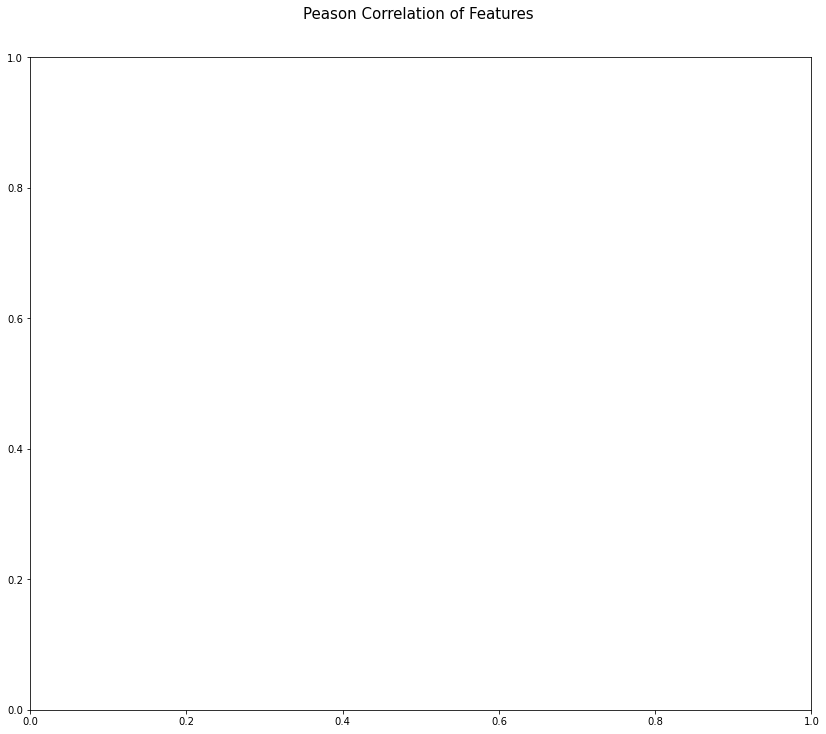

In [6]:

colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title("Peason Correlation of Features ", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)


In [8]:
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS )
splited = kf.split(train)


In [9]:
splited

<generator object _BaseKFold.split at 0x7f2c8ee9ac80>

In [10]:
class SklernHelper(object):

    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)



def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(ntrain)):
        x_tr = x_train[train_index]
        x_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)


In [11]:
rf_params = {
    'n_jobs' : -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
 'n_estimators': 500,
 'learning_rate': 0.75
}



In [12]:
rf = SklernHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

et = SklernHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)

ada = SklernHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)


In [13]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train =train.values
x_test = test.values
